# Setup

In [155]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from gplearn.genetic import SymbolicRegressor,SymbolicTransformer
from gplearn.functions import make_function

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV

import os

print(os.listdir("../input"))
print(os.listdir("../input/LANL-Earthquake-Prediction"))
print(os.listdir("../input/lanl-features"))

['LANL-Earthquake-Prediction', 'lanl-features']
['test', 'train.csv', 'sample_submission.csv']
['test_features_denoised.csv', 'submission_1.csv', 'train_features_denoised.csv', 'train_features.csv', 'y.csv', 'test_features.csv']


# Read Data

In [156]:
X = pd.read_csv('../input/lanl-features/train_features_denoised.csv')
X_test = pd.read_csv('../input/lanl-features/test_features_denoised.csv')
y = pd.read_csv('../input/lanl-features/y.csv')
submission = pd.read_csv('../input/LANL-Earthquake-Prediction/sample_submission.csv',index_col='seg_id')

# Scaling

In [157]:
X.drop('seg_id',axis=1,inplace=True)
X_test.drop('seg_id',axis=1,inplace=True)
X.drop('target',axis=1,inplace=True)
X_test.drop('target',axis=1,inplace=True)

alldata = pd.concat([X, X_test])

scaler = StandardScaler()

alldata = pd.DataFrame(scaler.fit_transform(alldata), columns=alldata.columns)

X = alldata[:X.shape[0]]
X_test = alldata[X.shape[0]:]

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


# Feature Selection

## Drop highly correlated features

In [158]:
%%time
corr_matrix = X.corr()
corr_matrix = corr_matrix.abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

X = X.drop(to_drop, axis=1)
X_test = X_test.drop(to_drop, axis=1)
print(X.shape)
print(X_test.shape)

(4195, 334)
(2624, 334)
CPU times: user 9.1 s, sys: 36 ms, total: 9.14 s
Wall time: 9.14 s


## Recursive feature elimination with cross validation and random forest regression

In [159]:
%%time
rf = RandomForestRegressor(n_estimators=10)
rfecv = RFECV(estimator=rf, step=1, cv=5, scoring='neg_mean_absolute_error', verbose=0, n_jobs=4) #4-fold cross-validation with mae
rfecv = rfecv.fit(X, y.values)
print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X.columns[rfecv.support_])

X = X[X.columns[rfecv.support_].values]
X_test = X_test[X_test.columns[rfecv.support_].values]
print(X.shape)
print(X_test.shape)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Optimal number of features : 13
Best features : Index(['abs_percentile_80', 'autocorrelation_1000', 'autocorrelation_10000',
       'autocorrelation_5', 'autocorrelation_5000',
       'av_change_rate_roll_std_500', 'ffti_av_change_abs_roll_std_100',
       'ffti_classic_sta_lta8_mean', 'ffti_skew', 'ffti_spkt_welch_density_10',
       'fftr_mean_change_rate_last_1000', 'num_crossing_0',
       'percentile_roll_std_10'],
      dtype='object')
(4195, 13)
(2624, 13)
CPU times: user 5min 43s, sys: 308 ms, total: 5min 43s
Wall time: 12min 2s


Give training data some insight of the time range of this experiment. Little bit cheating

In [160]:
X["mean_y"] = np.full(len(y), y.values.mean())
X["max_y"] = np.full(len(y), y.values.max())
X["min_y"] = np.full(len(y), y.values.min())
X["std_y"] = np.full(len(y), y.values.std())

X_test["mean_y"] = np.full(len(X_test), y.values.mean())
X_test["max_y"] = np.full(len(X_test), y.values.max())
X_test["min_y"] = np.full(len(X_test), y.values.min())
X_test["std_y"] = np.full(len(X_test), y.values.std())

print(X.shape)
print(X_test.shape)

(4195, 17)
(2624, 17)


In [184]:
list(X.columns)

['abs_percentile_80',
 'autocorrelation_1000',
 'autocorrelation_10000',
 'autocorrelation_5',
 'autocorrelation_5000',
 'av_change_rate_roll_std_500',
 'ffti_av_change_abs_roll_std_100',
 'ffti_classic_sta_lta8_mean',
 'ffti_skew',
 'ffti_spkt_welch_density_10',
 'fftr_mean_change_rate_last_1000',
 'num_crossing_0',
 'percentile_roll_std_10',
 'mean_y',
 'max_y',
 'min_y',
 'std_y']

# Define More Genetic Functions

In [161]:
def tanh(x):
    return np.tanh(x)
def sinh(x):
    return np.sinh(x)
def cosh(x):
    return np.cosh(x)
def arctan(x):
    return np.arctan(x)
def arcsin(x):
    return np.arcsin(x)
def arccos(x):
    return np.arccos(x)
def arctanh(x):
    return np.arctan(x)
def arcsinh(x):
    return np.arcsin(x)
def arccosh(x):
    return np.arccos(x)
def exp(x):
    return np.exp(x)
def exp2(x):
    return np.exp2(x)
def expm1(x):
    return np.expm1(x)
def log2(x):
    return np.log2(x)
def log1p(x):
    return np.log1p(x)
 

gp_tanh = make_function(tanh,"tanh",1)
gp_sinh = make_function(sinh,"sinh",1)
gp_cosh = make_function(cosh,"cosh",1)

gp_arctan = make_function(arctan,"arctan",1)
gp_arcsin = make_function(arcsin,"arcsin",1)
gp_arccos = make_function(arccos,"arccos",1)

gp_arctanh = make_function(arctanh,"arctanh",1)
gp_arcsinh = make_function(arcsinh,"arcsinh",1)
gp_arccosh = make_function(arccosh,"arccosh",1)

gp_exp = make_function(exp,"exp",1)
gp_exp2 = make_function(exp2,"exp2",1)
gp_expm1 = make_function(expm1,"expm1",1)
#gp_log2 = make_function(log2,"log2",1)
#gp_log1p = make_function(log1p,"log1p",1)

# Define Symbolic Regressor and Train

In [187]:
%%time
est_gp = SymbolicRegressor(population_size=X.shape[1]*17*10,
                           tournament_size=X.shape[1]*17//1,
                           generations=50, stopping_criteria=1.79,
                           p_crossover=0.9, p_subtree_mutation=0.0001, p_hoist_mutation=0.0001, p_point_mutation=0.0001,
                           max_samples=0.8, verbose=1,
                           function_set = ('add', 'sub', 'mul', 'div', 
                                           'sqrt', 'log', 'abs', 'neg', 'inv','max', 'min', 
                                           'tan', 'cos', 'sin', 
                                           gp_tanh, #gp_sinh, gp_cosh,
                                           gp_arctan, #gp_arcsin, gp_arccos,
                                           gp_arctanh, #gp_arcsinh, gp_arccosh,
                                           #gp_exp,
                                           #gp_exp2,
                                           #gp_expm1,
                                           #gp_log1p,                                           
                                          ),
                           #function_set = (gp_tanh, 'add', 'sub', 'mul', 'div'),
                           metric = 'mean absolute error', warm_start=True,
                           n_jobs = 4, parsimony_coefficient=0.00001, random_state=11)
'''

est_gp = SymbolicTransformer(population_size=1000, 
                             hall_of_fame=100, 
                             n_components=10, 
                             generations=20, 
                             tournament_size=20, 
                             stopping_criteria=1.0, 
                             const_range=(-1.0, 1.0), 
                             init_depth=(2, 6), 
                             init_method='half and half', 
                             function_set=('add', 'sub', 'mul', 'div'), 
                             metric='pearson', 
                             parsimony_coefficient=0.001, p_crossover=0.9, p_subtree_mutation=0.01, p_hoist_mutation=0.01, p_point_mutation=0.01, p_point_replace=0.05, max_samples=1.0, 
                             feature_names=None, warm_start=False, low_memory=False, n_jobs=4, verbose=1, random_state=11)
 '''

est_gp.fit(X, y)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


   0     7.85          10.3422       12          2.99863          3.00686      4.71m
   1     6.45          9.62204       13          2.64898          2.65785      4.24m
   2    11.30          6.87146       14          2.43764          2.45082      6.49m
   3     8.82          8.22432        8           2.3151          2.39197      5.33m
   4     5.57          3.20804       13          2.21993          2.34166      4.50m
   5    11.37          3.60411       13          2.20611          2.39694      4.61m
   6    12.70           3.7395       13          2.20725          2.39238      5.85m
   7    13.20          3.72859       13            2.197          2.43336      4.79m
   8    12.94          3.63324       13          2.20756          2.39114      4.66m
   9    13.02          3.70504       13          2.20125          2.41636      4.66m
  10    13.00          3.71016       13          2.20493          2.40164      5.49m
  11    13.03          3.67089       13           2.2008         

## Formula

In [188]:
#print("gpLearn Program:", est_gp._program)
genetic_formula = str(est_gp._program)
for i in range(len(X.columns)):
    genetic_formula = genetic_formula.replace(f'X{i}', X.columns[i])
    
print("Genetic Formula: ", genetic_formula)

Genetic Formula:  sub(add(sub(add(sub(autocorrelation_10003, autocorrelation_10001), -0.299), sin(autocorrelation_10001)), -0.299), sin(autocorrelation_10001))


## Prediction

In [189]:
y_gp = est_gp.predict(X)
gpLearn_MAE = mean_absolute_error(y, y_gp)
print("gpLearn MAE:", gpLearn_MAE)

gpLearn MAE: 2.099577617011157


In [190]:
df_result = pd.DataFrame()
df_result["predict"] = y_gp
df_result["real"] = y

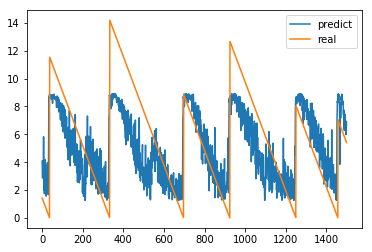

In [191]:
df_result[:1500].plot()

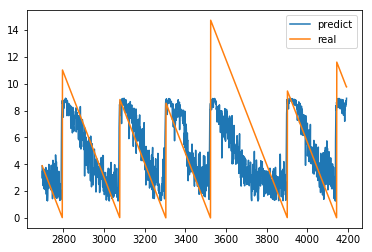

In [192]:
df_result[-1500:].plot()

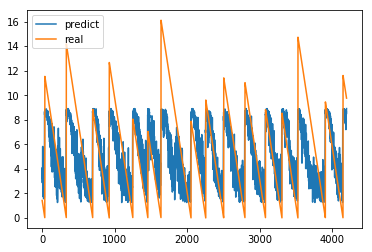

In [193]:
df_result.plot()

## Submission

In [194]:
submission.time_to_failure = est_gp.predict(X_test)
submission.to_csv('submission.csv', index=True)

In [195]:
submission.head(10)

,time_to_failure
seg_id,
seg_00030f,4.279934
seg_0012b5,4.732133
seg_00184e,5.449688
seg_003339,8.283347
seg_0042cc,5.443126
seg_004314,1.578514
seg_004cd2,6.690328
seg_004ee5,3.231288
seg_004f1f,3.649851
